In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import time
import glob
import random
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import shutil
import lxml
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu

C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
dirlist = ['D:/x-ray chest/locating/TBX11K/imgs/health', 'D:/x-ray chest/locating/TBX11K/imgs/sick', 'D:/x-ray chest/locating/TBX11K/imgs/tb']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  8400    labels:  8400


In [5]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(8400,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy         3800
Sick            3800
Tuberculosis     800
Name: labels, dtype: int64


In [6]:
file_count = 800
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))

Sick            800
Healthy         800
Tuberculosis    800
Name: labels, dtype: int64
2400


In [7]:
df.head()

,file_paths,labels
0,D:/x-ray chest/locating/TBX11K/imgs/sick\s0265...,Sick
1,D:/x-ray chest/locating/TBX11K/imgs/health\h04...,Healthy
2,D:/x-ray chest/locating/TBX11K/imgs/sick\s1566...,Sick
3,D:/x-ray chest/locating/TBX11K/imgs/tb\tb1013.png,Tuberculosis
4,D:/x-ray chest/locating/TBX11K/imgs/sick\s2675...,Sick


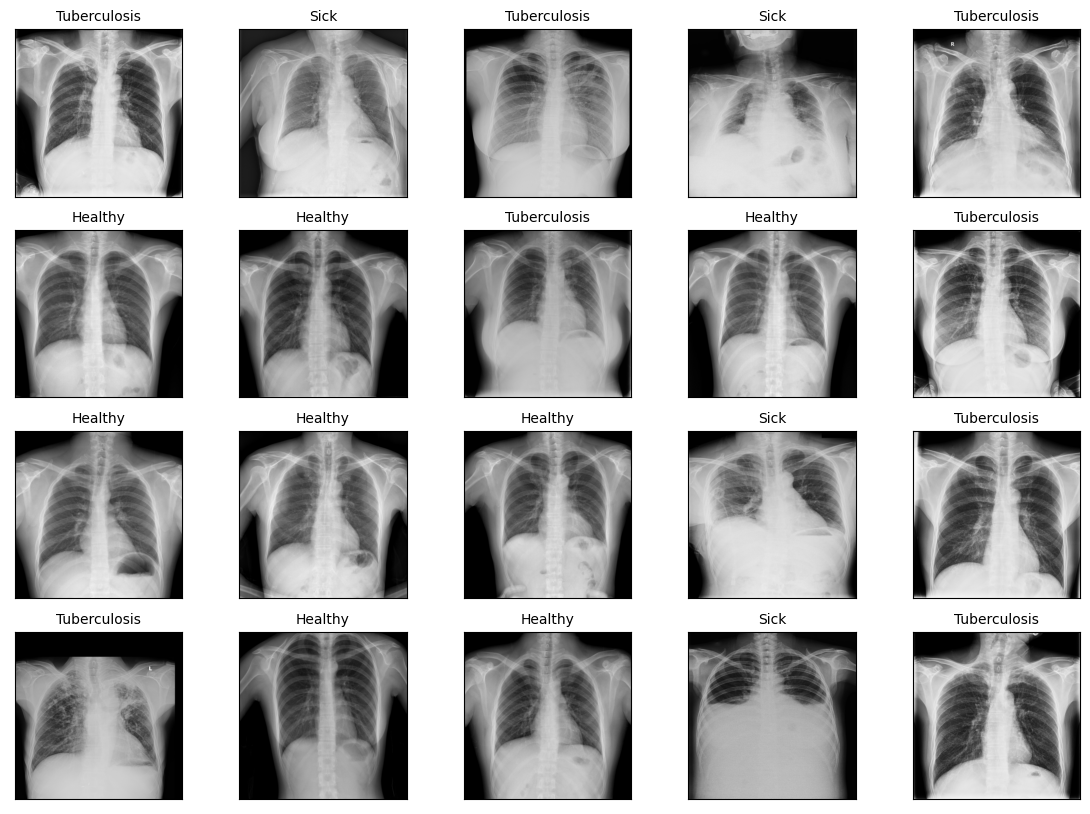

In [8]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

    
plt.show()

In [9]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Tuberculosis    685
Sick            684
Healthy         683
Name: labels, dtype: int64
Sick            79
Healthy         79
Tuberculosis    70
Name: labels, dtype: int64
Tuberculosis    45
Healthy         38
Sick            37
Name: labels, dtype: int64


In [22]:
target_size=(150,150)
batch_size=4

In [32]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input) # Reduce from a higher value
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical'
)
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical'
)

test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 2052 validated image filenames belonging to 3 classes.
Found 228 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


In [33]:
# Load VGG16 model with pretrained weights
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(150, 150, 3), weights='imagenet')

# Freeze the base model layers to retain the pretrained features
base_model.trainable = False

# Build the classification model
classify_model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')
])

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [29]:
lr=0.001
classify_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

In [30]:
patience = 2
stop_patience = 5
factor = 0.5

callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint("classify_model.h5", monitor='val_loss', save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [31]:
epochs = 30
history = classify_model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_4/vgg16/block1_conv1/Relu' defined at (most recent call last):
    File "c:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\anshs\AppData\Local\Temp\ipykernel_5628\87186150.py", line 2, in <module>
      history = classify_model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks=callbacks, verbose=1)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\anshs\AppData\Roaming\Python\Python310\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_4/vgg16/block1_conv1/Relu'
OOM when allocating tensor with shape[4,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_4/vgg16/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_178452]